In [69]:
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [70]:
# Function to calculate distance between two lat-lng points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Distance in kilometers
    distance = R * c
    return distance

In [71]:
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
filepath = '/content/drive/My Drive/merged_rides_with_elevation.csv'

In [74]:
df = pd.read_csv(filepath)

In [75]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Start_Altitude,End_Altitude,end_altitude,end_Altitude,Start_Altutude,State_Altitude,Elevation_Change
0,C2F7DD78E82EC875,electric_bike,1/13/2022 11:59,1/13/2022 12:02,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012800,-87.665906,42.012560,-87.674367,casual,184.1,603.6,NaN,NaN,NaN,NaN,419.5
1,A6CF8980A652D272,electric_bike,1/10/2022 8:41,1/10/2022 8:46,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.012763,-87.665967,42.012560,-87.674367,casual,184.6,603.6,NaN,NaN,NaN,NaN,419.0
2,BD0F91DFF741C66D,classic_bike,1/25/2022 4:53,1/25/2022 4:58,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.925602,-87.653708,41.925330,-87.665800,member,181.7,592.5,NaN,NaN,NaN,NaN,410.8
3,CBB80ED419105406,classic_bike,1/4/2022 0:18,1/4/2022 0:33,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.983593,-87.669154,41.961507,-87.671387,casual,182.9,598.1,NaN,NaN,NaN,NaN,415.2
4,DDC963BFDDA51EEA,classic_bike,1/20/2022 1:31,1/20/2022 1:37,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.877850,-87.624080,41.884621,-87.627834,member,182.5,594.7,NaN,NaN,NaN,NaN,412.2


In [76]:
df['Start_Altitude'] = df[['Start_Altitude', 'Start_Altutude', 'State_Altitude']].bfill(axis=1).iloc[:, 0]

In [77]:
df.drop(columns=['State_Altitude', 'Start_Altutude'], inplace=True)


In [78]:
df['End_Altitude'] = df[['End_Altitude', 'end_altitude', 'end_Altitude']].bfill(axis=1).iloc[:, 0]

In [79]:
df.drop(columns=['end_Altitude', 'end_altitude'], inplace=True)

In [80]:
df['Start_Altitude'].fillna(method='ffill', inplace=True)
df['End_Altitude'].fillna(df['End_Altitude'].mean(), inplace=True)

In [81]:
from sklearn.impute import SimpleImputer
df['Elevation_Change'] = df['End_Altitude'] - df['Start_Altitude']

In [82]:
imputer = SimpleImputer(strategy='mean')
df['Elevation_Change'] = imputer.fit_transform(df[['Elevation_Change']])

In [83]:
df = df.drop(columns=['Start_Altitude', 'End_Altitude'])

In [84]:
df['Distance'] = df.apply(lambda x: haversine_distance(x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']), axis=1)

In [85]:
df = df.drop(columns=['start_lat', 'start_lng', 'end_lat', 'end_lng'])

In [86]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [87]:
df['season'] = df['started_at'].dt.month.map(get_season)

In [88]:
def get_day_of_week(timestamp):
    return timestamp.strftime("%A")

In [89]:
# Apply the function to each row in the DataFrame
df['day_of_week'] = df['started_at'].apply(get_day_of_week)

In [90]:
df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

In [91]:
weatherData = '/content/drive/My Drive/3667056.csv'

In [92]:
tempData = pd.read_csv(weatherData)

In [93]:
tempData['started_at'] = pd.to_datetime(tempData['DATE'])
tempData['started_at'] = tempData['started_at'].dt.date

In [94]:
df['started_at'] = df['started_at'].dt.date

In [95]:
df = pd.merge(df, tempData[['started_at', 'TMAX', 'TMIN']], on='started_at', how='left')

In [ ]:
# ride_types = dfs['rideable_type'].unique()

In [ ]:
# print(ride_types)

['electric_bike' 'classic_bike' 'docked_bike']


In [96]:
df['rideable_type'] = df['rideable_type'].replace({
    'electric_bike': 'electric',
    'docked_bike': 'classic',
    'classic_bike': 'classic'
})

In [97]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,Elevation_Change,Distance,season,day_of_week,trip_duration,TMAX,TMIN
0,C2F7DD78E82EC875,electric,2022-01-13,2022-01-13 12:02:00,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,casual,419.5,0.699547,Winter,Thursday,3.0,41,29
1,A6CF8980A652D272,electric,2022-01-10,2022-01-10 08:46:00,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,casual,419.0,0.694322,Winter,Monday,5.0,20,8
2,BD0F91DFF741C66D,classic,2022-01-25,2022-01-25 04:58:00,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,member,410.8,1.000832,Winter,Tuesday,5.0,15,2
3,CBB80ED419105406,classic,2022-01-04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,casual,415.2,2.462779,Winter,Tuesday,15.0,36,24
4,DDC963BFDDA51EEA,classic,2022-01-20,2022-01-20 01:37:00,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,member,412.2,0.814537,Winter,Thursday,6.0,22,9


In [98]:
df.fillna(df.mean(numeric_only=True), inplace=True)  # Only fill numeric columns with their means
df.fillna('Unknown', inplace=True)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [116]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'member_casual', 'Elevation_Change', 'Distance',
       'season', 'day_of_week', 'trip_duration', 'TMAX', 'TMIN'],
      dtype='object')

In [101]:
target_variable = 'rideable_type'
y = df[target_variable]
X = df.drop(target_variable, axis=1)

In [102]:
X.columns

Index(['ride_id', 'started_at', 'ended_at', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id',
       'member_casual', 'Elevation_Change', 'Distance', 'season',
       'day_of_week', 'trip_duration', 'TMAX', 'TMIN'],
      dtype='object')

In [117]:
target_variable = 'rideable_type'
y = df[target_variable]
c = ['ride_id', 'started_at', 'ended_at', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id',
       'member_casual','TMAX', 'TMIN']
X = df.drop(c, axis=1)

In [118]:
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object':  # This identifies categorical columns
        num_unique_values = len(X[column].unique())
        if num_unique_values < 10:  # Limit set for one-hot encoding
            # Apply one-hot encoding to columns with fewer unique values
            dummies = pd.get_dummies(X[column], prefix=column)
            X = pd.concat([X, dummies], axis=1)
        else:
            # Apply label encoding to columns with many unique values to save memory
            label_encoders[column] = LabelEncoder()
            X[column] = label_encoders[column].fit_transform(X[column].astype(str))
        X.drop(column, axis=1, inplace=True)  # Drop original column after encoding

In [119]:
X.columns

Index(['Elevation_Change', 'Distance', 'trip_duration',
       'rideable_type_classic', 'rideable_type_electric', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [122]:
k=['rideable_type_classic', 'rideable_type_electric']
X = X.drop(k, axis=1)

In [123]:
X.columns

Index(['Elevation_Change', 'Distance', 'trip_duration', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [124]:
y_train

2220921     electric
6189410      classic
587405      electric
10376738     classic
3510934      classic
              ...   
2234489     electric
4304572     electric
10081351    electric
6550634     electric
6423388     electric
Name: rideable_type, Length: 7971288, dtype: object

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [126]:
y_train_encoded = (y_train == 'electric').astype(int)  # Encode 'electric' as 1, 'classic' as 0
y_test_encoded = (y_test == 'electric').astype(int)

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [128]:
model = LinearRegression()


In [129]:
X_train.columns

Index(['Elevation_Change', 'Distance', 'trip_duration', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [38]:
X_train.drop(columns=['ended_at'], inplace=True)

In [130]:
print(X_train.dtypes)
print(y_train_encoded)

Elevation_Change         float64
Distance                 float64
trip_duration            float64
season_Fall                 bool
season_Spring               bool
season_Summer               bool
season_Winter               bool
day_of_week_Friday          bool
day_of_week_Monday          bool
day_of_week_Saturday        bool
day_of_week_Sunday          bool
day_of_week_Thursday        bool
day_of_week_Tuesday         bool
day_of_week_Wednesday       bool
dtype: object
2220921     1
6189410     0
587405      1
10376738    0
3510934     0
           ..
2234489     1
4304572     1
10081351    1
6550634     1
6423388     1
Name: rideable_type, Length: 7971288, dtype: int64


In [40]:
X_test.drop(columns=['ended_at'], inplace=True)

In [131]:
X_test.columns

Index(['Elevation_Change', 'Distance', 'trip_duration', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [132]:
X_train.columns

Index(['Elevation_Change', 'Distance', 'trip_duration', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [133]:
# Fit the model on the training data with encoded labels
model.fit(X_train, y_train_encoded)

LinearRegression()

In [134]:
y_pred = model.predict(X_test)

In [135]:
y_pred

array([0.49795336, 0.51080862, 0.54090203, ..., 0.54241759, 0.51098568,
       0.53107088])

In [136]:
mse = mean_squared_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.24913603926797523
R² Score: 0.0028416878294040826


In [137]:
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print(coefficients)

                       Coefficient
Elevation_Change         -0.000176
Distance                 -0.000019
trip_duration            -0.000089
season_Fall               0.009278
season_Spring             0.000363
season_Summer            -0.020343
season_Winter             0.010702
day_of_week_Friday        0.017354
day_of_week_Monday       -0.006464
day_of_week_Saturday     -0.016227
day_of_week_Sunday       -0.020194
day_of_week_Thursday      0.013634
day_of_week_Tuesday       0.000531
day_of_week_Wednesday     0.011367


In [138]:
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report

In [139]:
y_pred = model.predict(X_test)  # This should be predictions on the test set
y_pred_encoded = (y_pred > 0.5).astype(int)

In [140]:
recall = recall_score(y_test_encoded, y_pred_encoded)  # pos_label defaults to 1 which is suitable here
f1 = f1_score(y_test_encoded, y_pred_encoded)

In [141]:
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# For a comprehensive report including precision and support per class
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)

Recall: 0.7432867282672341
F1-Score: 0.6152634893974386
              precision    recall  f1-score   support

           0       0.52      0.29      0.37   1665742
           1       0.52      0.74      0.62   1750525

    accuracy                           0.52   3416267
   macro avg       0.52      0.52      0.50   3416267
weighted avg       0.52      0.52      0.50   3416267



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)  # Hyperparameters can be adjusted
gb_regressor.fit(X_train, y_train_encoded)

GradientBoostingRegressor(random_state=42)

In [ ]:
y_pred = gb_regressor.predict(X_test)

In [ ]:
feature_importances = gb_regressor.feature_importances_


In [ ]:
feature_names = X_train.columns

In [ ]:
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(importances_df)

                  Feature  Importance
1                Distance    0.498346
2           trip_duration    0.416795
0        Elevation_Change    0.050170
6    member_casual_casual    0.019550
7    member_casual_member    0.010294
4                    TMIN    0.002744
3                    TMAX    0.000775
8             season_Fall    0.000307
10          season_Summer    0.000297
9           season_Spring    0.000266
12     day_of_week_Friday    0.000125
15     day_of_week_Sunday    0.000122
11          season_Winter    0.000104
14   day_of_week_Saturday    0.000092
13     day_of_week_Monday    0.000013
5   member_casual_Unknown    0.000000
16   day_of_week_Thursday    0.000000
17    day_of_week_Tuesday    0.000000
18  day_of_week_Wednesday    0.000000


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Assuming gb_regressor is your trained gradient boosting regression model
predictions = gb_regressor.predict(X_test)  # X_test is your test data

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_encoded, y_pred)
mse = mean_squared_error(y_test_encoded, y_pred)
rmse = mean_squared_error(y_test_encoded, y_pred, squared=False)  # RMSE
r2 = r2_score(y_test_encoded, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 0.41125352854674235
Mean Squared Error: 0.19575479960088926
Root Mean Squared Error: 0.44244186013632264
R-squared: 0.21649823870180052


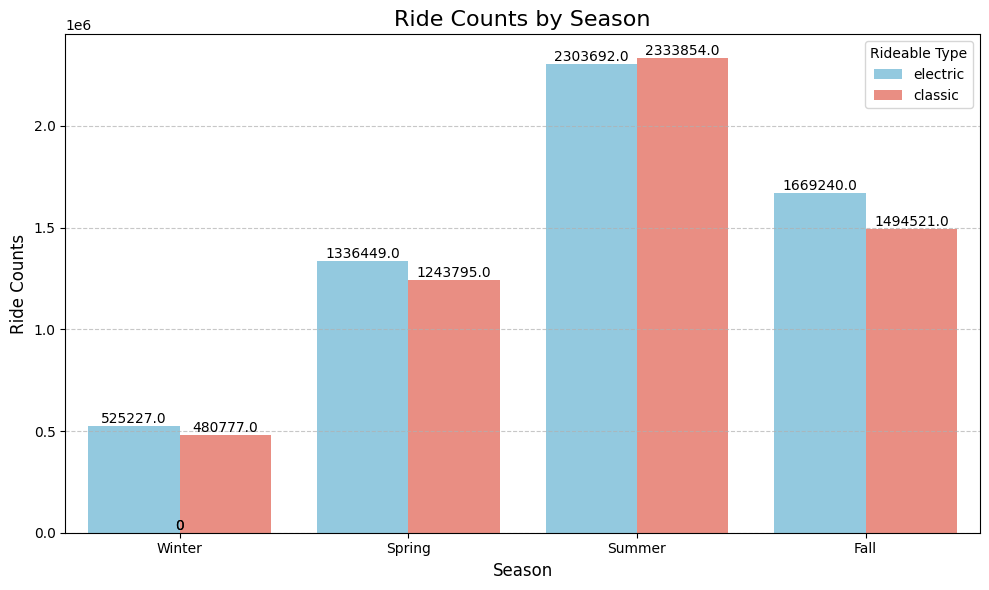

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'started_at' column to datetime objects
df['started_at'] = pd.to_datetime(df['started_at'])

# Define custom color palette
custom_palette = {"electric": "skyblue", "classic": "salmon"}

# Plot ride counts by season for electric and classic bikes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='season', hue='rideable_type', palette=custom_palette)
plt.title('Ride Counts by Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Ride Counts', fontsize=12)
plt.xticks(fontsize=10)  # Adjust tick label font size
plt.yticks(fontsize=10)
plt.legend(title='Rideable Type', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()

# Add annotations
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()


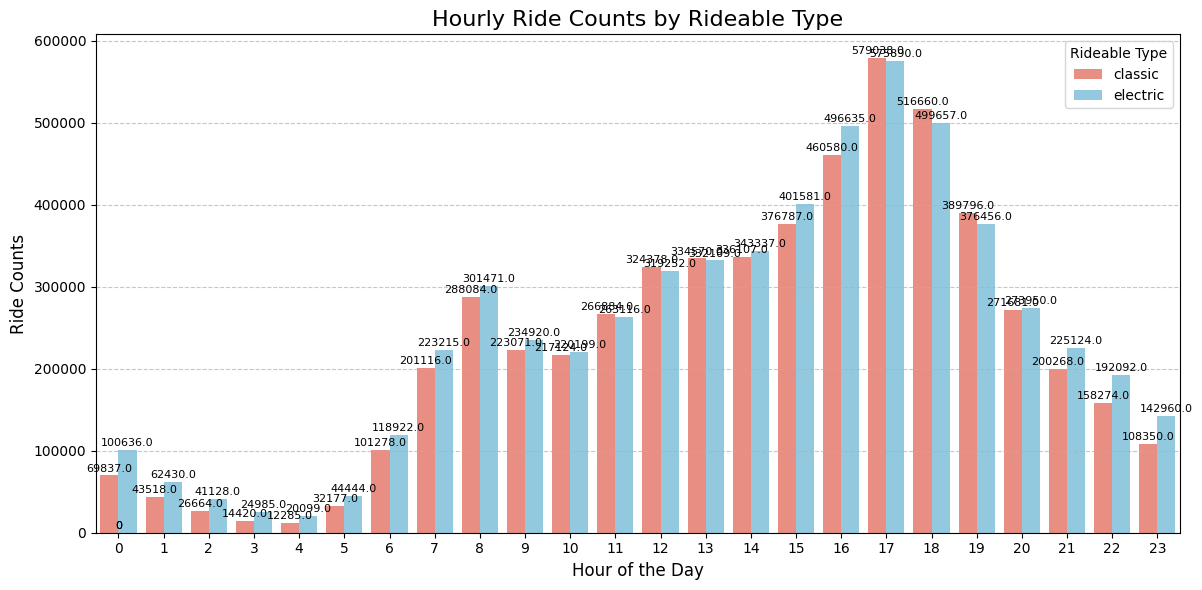

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette
# custom_palette = {"electric": "skyblue", "classic": "salmon", "escooter": "lightgreen"}
custom_palette = {"electric": "skyblue", "classic": "salmon"}

# Plot hourly ride counts for bike and escooter
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour', hue='rideable_type', palette=custom_palette)
plt.title('Hourly Ride Counts by Rideable Type', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Ride Counts', fontsize=12)
plt.legend(title='Rideable Type', fontsize=10)
plt.xticks(range(24), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()

# Add annotations
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()


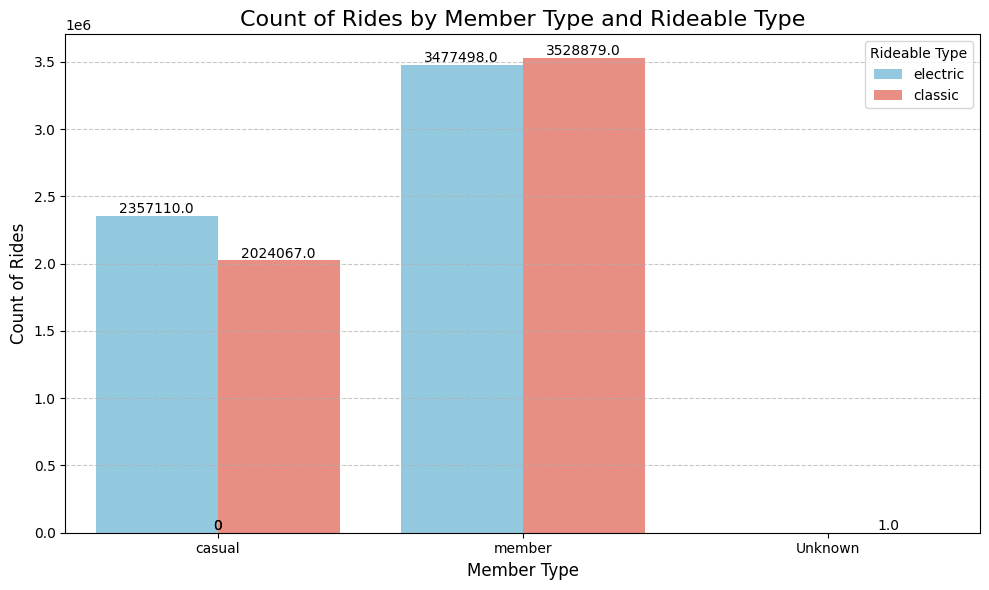

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette
custom_palette = {"electric": "skyblue", "classic": "salmon"}

# Plot count of rides by member type and rideable type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='member_casual', hue='rideable_type', palette=custom_palette)
plt.title('Count of Rides by Member Type and Rideable Type', fontsize=16)
plt.xlabel('Member Type', fontsize=12)
plt.ylabel('Count of Rides', fontsize=12)
plt.legend(title='Rideable Type', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()

# Add annotations
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()


In [ ]:
df['year'] = df['started_at'].dt.year
df['month'] = df['started_at'].dt.month

In [ ]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'member_casual', 'Elevation_Change', 'Distance',
       'season', 'day_of_week', 'trip_duration', 'TMAX', 'TMIN', 'hour',
       'year', 'month'],
      dtype='object')

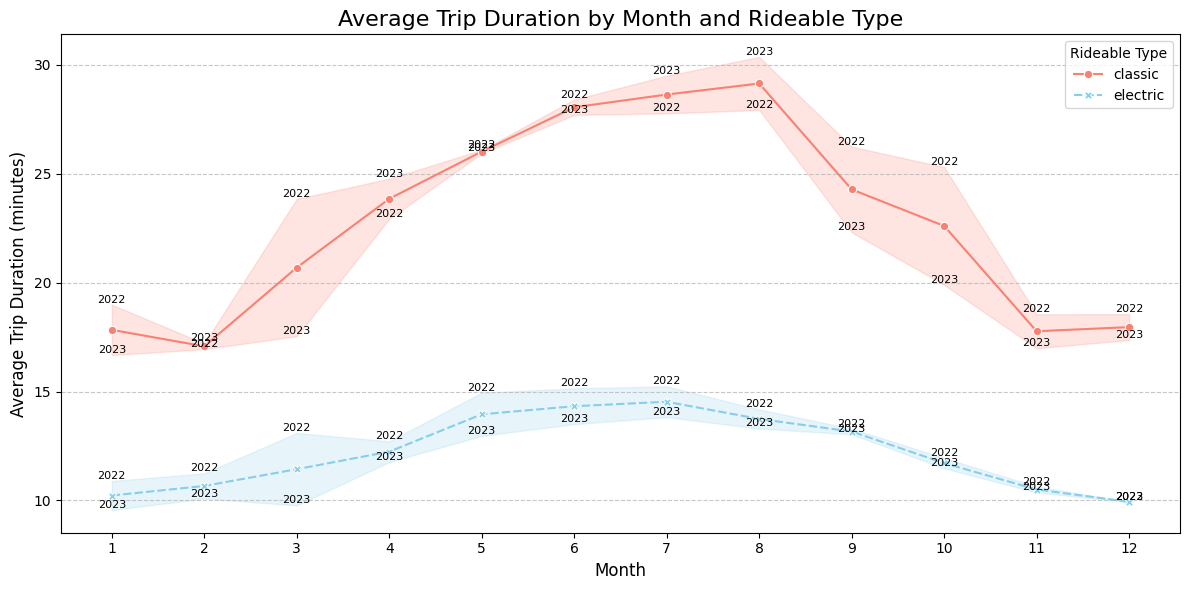

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette
custom_palette = {"electric": "skyblue", "classic": "salmon"}

# Plot average trip duration on a monthly basis, differentiated by rideable type
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_trip_duration, x='month', y='trip_duration', hue='rideable_type', style='rideable_type', markers=True, palette=custom_palette)
plt.title('Average Trip Duration by Month and Rideable Type', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Trip Duration (minutes)', fontsize=12)
plt.xticks(range(1, 13), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Rideable Type', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()

# Add annotations
for line in range(0, monthly_avg_trip_duration.shape[0]):
    plt.text(monthly_avg_trip_duration['month'][line], monthly_avg_trip_duration['trip_duration'][line],
             monthly_avg_trip_duration['year'][line], horizontalalignment='center',
             verticalalignment='bottom', fontsize=8, color='black')

plt.show()


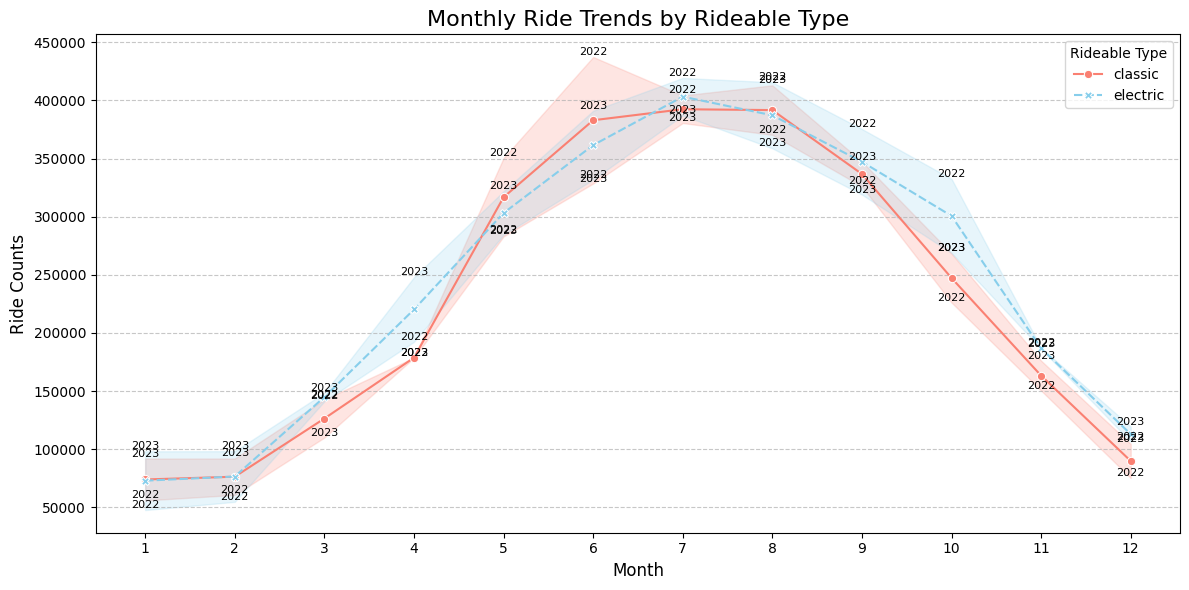

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette
custom_palette = {"electric": "skyblue", "classic": "salmon"}

# Plot monthly trends for each rideable type
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_ride_counts, x='month', y='ride_counts', hue='rideable_type', style='rideable_type', markers=True, palette=custom_palette)
plt.title('Monthly Ride Trends by Rideable Type', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Ride Counts', fontsize=12)
plt.xticks(range(1, 13), fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Rideable Type', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
plt.tight_layout()

# Add annotations
for line in range(0, monthly_ride_counts.shape[0]):
    plt.text(monthly_ride_counts['month'][line], monthly_ride_counts['ride_counts'][line],
             monthly_ride_counts['year'][line], horizontalalignment='center',
             verticalalignment='bottom', fontsize=8, color='black')

plt.show()


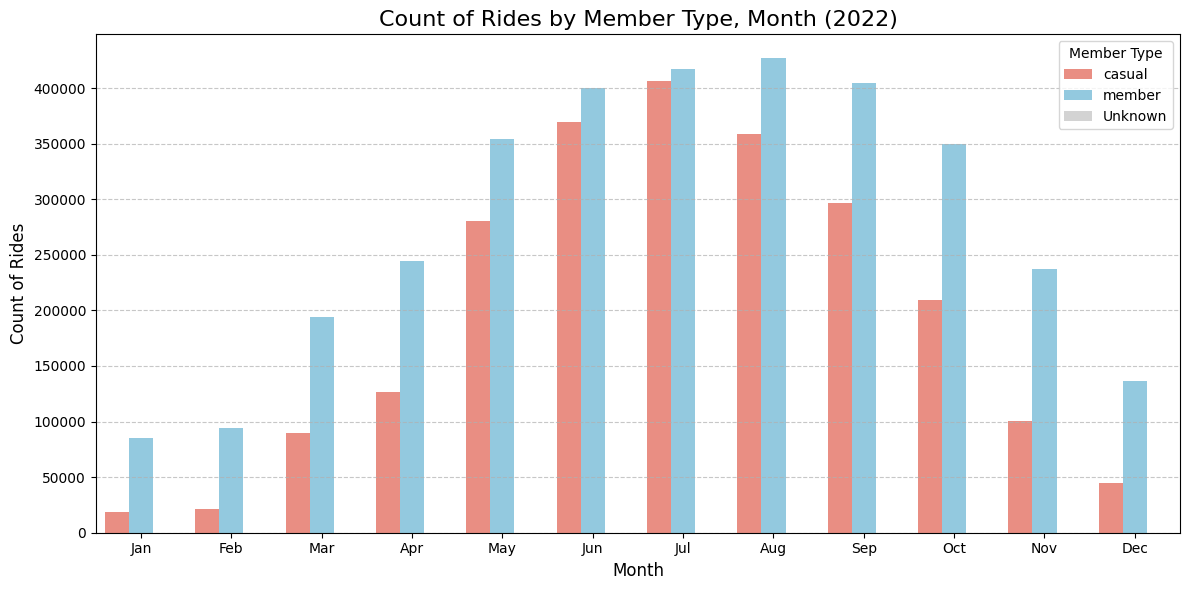

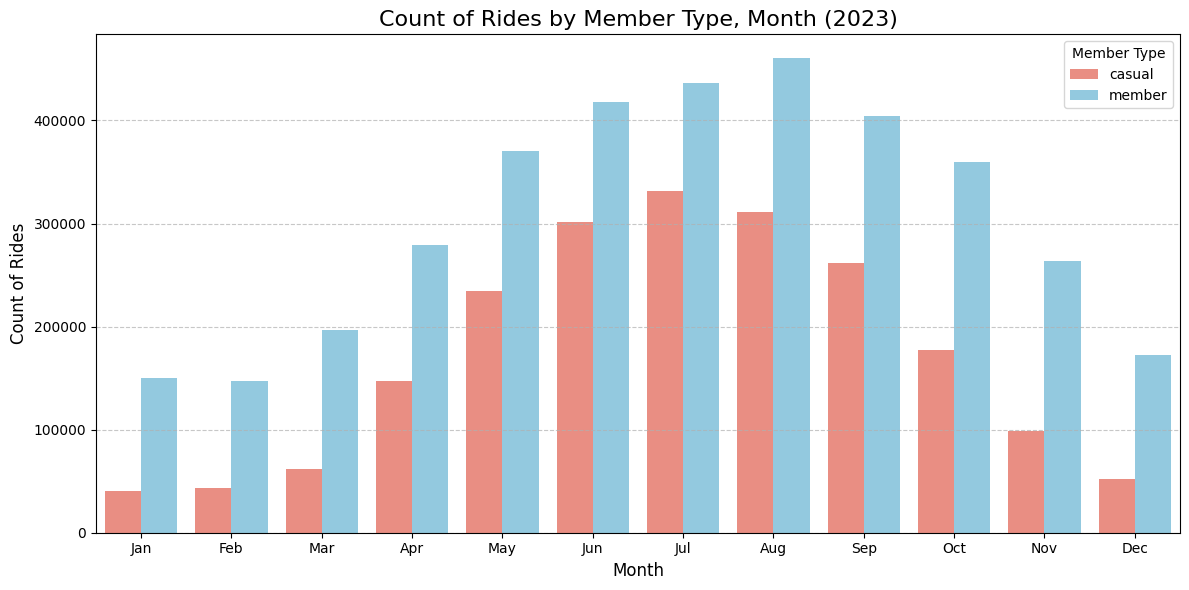

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color palette
custom_palette = {"member": "skyblue", "casual": "salmon", "Unknown": "lightgray"}

# Plot the count of rides by member type, year, and month
for year in df['year'].unique():
    plt.figure(figsize=(12, 6))
    ride_counts_year = ride_counts[ride_counts['year'] == year]
    sns.barplot(data=ride_counts_year, x='month', y='count', hue='member_casual', order=range(1, 13), palette=custom_palette)
    plt.title(f'Count of Rides by Member Type, Month ({year})', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Count of Rides', fontsize=12)
    plt.legend(title='Member Type', fontsize=10)
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
    plt.tight_layout()
    plt.show()


In [ ]:
#using only important features given by gradient boosting
X_important = X[['Distance', 'Elevation_Change', 'trip_duration']]

y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)

In [ ]:
model.fit(X_train, y_train_encoded)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)
y_pred_encoded = (y_pred > 0.5).astype(int)

mse = mean_squared_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 0.24952130063380545
R² Score: 0.0012996926430609568
                  Coefficient
Distance            -0.000021
Elevation_Change    -0.000139
trip_duration       -0.000091


In [ ]:
recall = recall_score(y_test_encoded, y_pred_encoded)  # pos_label defaults to 1 which is suitable here
f1 = f1_score(y_test_encoded, y_pred_encoded)
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# For a comprehensive report including precision and support per class
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)

Recall: 0.9906410933862698
F1-Score: 0.6772865140410228
              precision    recall  f1-score   support

           0       0.64      0.02      0.03   1665742
           1       0.51      0.99      0.68   1750525

    accuracy                           0.52   3416267
   macro avg       0.58      0.50      0.36   3416267
weighted avg       0.58      0.52      0.36   3416267



In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [143]:
model = LogisticRegression()

In [144]:
print(X_train.dtypes)
print(y_train_encoded)

Elevation_Change         float64
Distance                 float64
trip_duration            float64
season_Fall                 bool
season_Spring               bool
season_Summer               bool
season_Winter               bool
day_of_week_Friday          bool
day_of_week_Monday          bool
day_of_week_Saturday        bool
day_of_week_Sunday          bool
day_of_week_Thursday        bool
day_of_week_Tuesday         bool
day_of_week_Wednesday       bool
dtype: object
2220921     1
6189410     0
587405      1
10376738    0
3510934     0
           ..
2234489     1
4304572     1
10081351    1
6550634     1
6423388     1
Name: rideable_type, Length: 7971288, dtype: int64


In [145]:
model.fit(X_train, y_train_encoded)

LogisticRegression()

In [ ]:
X_important = X[['Distance', 'Elevation_Change', 'trip_duration']]

y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)

In [146]:
y_pred = model.predict(X_test)
y_pred_encoded = (y_pred > 0.5).astype(int)

mse = mean_squared_error(y_test_encoded, y_pred)
r2 = r2_score(y_test_encoded, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

coefficients = pd.DataFrame(model.coef_.T, X_train.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 0.4424835646628323
R² Score: -0.7710250423778622
                       Coefficient
Elevation_Change         -0.000671
Distance                  0.000095
trip_duration            -0.014597
season_Fall               0.083438
season_Spring             0.069393
season_Summer             0.001189
season_Winter             0.043723
day_of_week_Friday        0.094066
day_of_week_Monday       -0.004058
day_of_week_Saturday     -0.002810
day_of_week_Sunday       -0.015210
day_of_week_Thursday      0.065395
day_of_week_Tuesday       0.009808
day_of_week_Wednesday     0.050551


In [147]:
recall = recall_score(y_test_encoded, y_pred_encoded)  # pos_label defaults to 1 which is suitable here
f1 = f1_score(y_test_encoded, y_pred_encoded)
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# For a comprehensive report including precision and support per class
report = classification_report(y_test_encoded, y_pred_encoded)
print(report)

Recall: 0.7923400122820297
F1-Score: 0.6472793947448984
              precision    recall  f1-score   support

           0       0.59      0.31      0.41   1665742
           1       0.55      0.79      0.65   1750525

    accuracy                           0.56   3416267
   macro avg       0.57      0.55      0.53   3416267
weighted avg       0.57      0.56      0.53   3416267

